See [here](http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) for details

And [here](http://danielhnyk.cz/predicting-sequences-vectors-keras-using-rnn-lstm/)

And [here](https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent)

# Imports

In [1]:
##########
# basics #
##########

import warnings
warnings.filterwarnings('ignore')
import collections
import datetime
import glob
import hashlib
import itertools
import math
import operator
import os
import pickle
import random
import re
import string
import sys
import time

###########
# science #
###########

import scipy as sp
import numpy as np
import pandas as pd
rseed = random.seed(42)

######
# ml #
######

import theano as thno
import keras as krs
import tensorflow as tf

###################
# sklearn tooling #
###################

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn import grid_search
from sklearn import pipeline
from sklearn import feature_selection

#################
# visualization #
#################

# plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import cufflinks as cf
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))
cf.set_config_file(offline=False, world_readable=False, theme='pearl')

# matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
mpl.rcParams['figure.figsize']=(12.0,4.0)
%matplotlib inline

# seaborn
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted', n_colors=15, desat=None)
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

############
# sys info #
############

%reload_ext watermark
%watermark -a "Ken Cavagnolo" -n -u -v -m -h -g -p numpy,scipy,pandas,sklearn,theano,keras,tensorflow,\
matplotlib,seaborn,plotly

Using TensorFlow backend.
/usr/local/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Ken Cavagnolo 
last updated: Mon Oct 10 2016 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
scipy 0.18.1
pandas 0.19.0
sklearn 0.18
theano 0.8.2
keras 1.1.0
tensorflow 0.10.0rc0
matplotlib 1.5.3
seaborn 0.7.1
plotly 1.12.9

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : ubuntu
Git hash   : 8e39dd6f127fdc0009b6a28fa1d8da1c3831da18


# Raw Data

In [2]:
df = pd.read_csv('../../datasets/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)

In [3]:
df.describe()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [4]:
df.head()

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


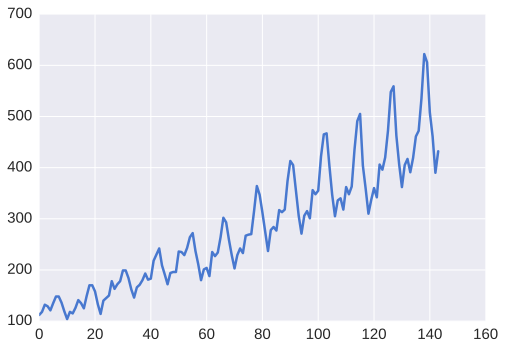

In [5]:
# below fails bc of bullshit zscaler ssl cert inspection
#df.iplot(legend=None)

plt.plot(df)

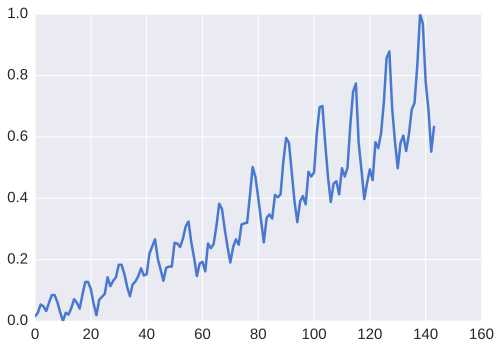

In [6]:
# scale data
scaler = preprocessing.MinMaxScaler()

# transform
df_scl = df.copy()
for c in df.columns:
    df_scl[[c]] = scaler.fit_transform(df[[c]])
    
# viz
plt.plot(df_scl)

# Functions

In [140]:
def pick_cv(data, folds=5):
    cv_min = round(0.5*len(data))
    cv_max = len(data)
    return list(set([random.randrange(cv_min, cv_max) for i in range(0, folds)]))

In [141]:
def lags(data, window=3):
    dX, dY = [], []
    for i in range(len(data)-window):
        dX.append(data.iloc[i:i+window].as_matrix())
        dY.append(data.iloc[i+window].as_matrix())
    return np.array(dX), np.array(dY)

# Train/Test

In [142]:
for i in pick_cv(df_scl, 1):
    train, test = df_scl.iloc[0:i], df_scl.iloc[i:]
    X_train, y_train = lags(train, 5)
    X_test, y_test = lags(test, 5)
    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Model

In [106]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error

In [113]:
model = Sequential()
model.add(LSTM(input_dim=X_train.shape[2],
               output_dim=50,
               return_sequences=True))

In [114]:
model.add(LSTM(output_dim=100,
               return_sequences=False))
model.add(Dropout(0.2))

In [115]:
model.add(Dense(output_dim=1))
model.add(Activation("linear"))

In [116]:
start = time.time()
model.compile(loss="mse", optimizer="adam")
print "Compilation Time : ", time.time() - start

Compilation Time :  2.07239508629


In [117]:
model.fit(X_train, y_train, nb_epoch=100, batch_size=10, verbose=2)

Epoch 1/100
0s - loss: 0.0302
Epoch 2/100
0s - loss: 0.0172
Epoch 3/100
0s - loss: 0.0083
Epoch 4/100
0s - loss: 0.0047
Epoch 5/100
0s - loss: 0.0046
Epoch 6/100
0s - loss: 0.0044
Epoch 7/100
0s - loss: 0.0040
Epoch 8/100
0s - loss: 0.0036
Epoch 9/100
0s - loss: 0.0037
Epoch 10/100
0s - loss: 0.0034
Epoch 11/100
0s - loss: 0.0034
Epoch 12/100
0s - loss: 0.0030
Epoch 13/100
0s - loss: 0.0030
Epoch 14/100
0s - loss: 0.0029
Epoch 15/100
0s - loss: 0.0029
Epoch 16/100
0s - loss: 0.0025
Epoch 17/100
0s - loss: 0.0025
Epoch 18/100
0s - loss: 0.0027
Epoch 19/100
0s - loss: 0.0023
Epoch 20/100
0s - loss: 0.0026
Epoch 21/100
0s - loss: 0.0023
Epoch 22/100
0s - loss: 0.0023
Epoch 23/100
0s - loss: 0.0022
Epoch 24/100
0s - loss: 0.0024
Epoch 25/100
0s - loss: 0.0023
Epoch 26/100
0s - loss: 0.0023
Epoch 27/100
0s - loss: 0.0019
Epoch 28/100
0s - loss: 0.0020
Epoch 29/100
0s - loss: 0.0019
Epoch 30/100
0s - loss: 0.0019
Epoch 31/100
0s - loss: 0.0020
Epoch 32/100
0s - loss: 0.0016
Epoch 33/100
0s -

# Validation

In [143]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

In [149]:
len(X_train)

82

In [147]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(5*2)+1:len(X_train)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

ValueError: could not broadcast input array from shape (52,1) into shape (0,1)

In [122]:
predicted

array([ 0.48546997,  0.42010608,  0.32114777,  0.26495641,  0.24305075,
        0.35200948,  0.35656601,  0.32187542,  0.37525505,  0.37533152,
        0.38021356,  0.48408121,  0.570557  ,  0.51203686,  0.36941332,
        0.30052096,  0.28865904,  0.40618837,  0.4152264 ,  0.35949081,
        0.45040119,  0.43289608,  0.44180304,  0.56475848,  0.66405571,
        0.61238509,  0.41871649,  0.33667898,  0.32251835,  0.45834702,
        0.45845625,  0.38559943,  0.45691812,  0.43080324,  0.46359986,
        0.59794462,  0.71956408,  0.6791873 ,  0.38107663,  0.33872652,
        0.32308239,  0.47230062,  0.49663472,  0.433357  ,  0.54094571,
        0.50293571,  0.55579817,  0.63400906,  0.81860006,  0.75614786,
        0.45773453,  0.36892003,  0.38442689,  0.5877223 ,  0.58778858,
        0.49447948,  0.52660096,  0.63879013,  0.64722145,  0.74850374,
        0.91711301,  0.79176396,  0.47223577,  0.42097229,  0.39858562], dtype=float32)

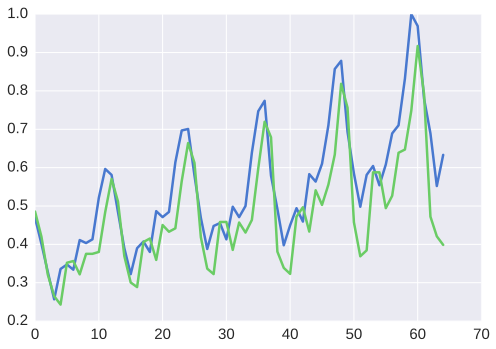

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test)
plt.plot(predicted)
plt.show()

# Scratch

In [80]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# load the dataset
dataframe = pd.read_csv('../../datasets/international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [82]:
trainX.shape

(94, 1, 1)

In [87]:
model = Sequential()
model.add(LSTM(4, input_dim=3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Exception: Error when checking model input: expected lstm_input_6 to have shape (None, None, 3) but got array with shape (94, 1, 1)